# Hate Speech Detector 2.0
---
**Lexical text classifier**
1. Load tweet min, mean and max POC scores for each hate-speech class.
2. Find optimal threshold values of above measures calculating for each single label binary classification F measure for positive examples (F1) as a quality score.
3. Perform 7-times binary classification task.
4. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
5. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.classifiers.LexicalClassifier import LexicalClassifier
from src.dataframes.utils import combine_row_wisely, shuffle_dataframe
from src.visualization.classification import confusion_matrices
from src.constants import (LABELS,
                           DUPLICATED_PATH, POC_SCORES_PATH)

In [2]:
plt.style.use('ggplot')

## Data loading

### Classes

In [3]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Tweet POC scores for each class

In [4]:
unused_fields = ['vulg_POC_min', 'vulg_POC_mean', 'vulg_POC_max']
df_poc_scores = pd.read_csv(POC_SCORES_PATH).drop(['id']+unused_fields, axis=1)
df_poc_scores.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,odcz_POC_max,pon_POC_min,pon_POC_mean,pon_POC_max,styg_POC_min,styg_POC_mean,styg_POC_max,szan_POC_min,szan_POC_mean,szan_POC_max
0,0.000000,0.000000,0.0,-0.5,-0.002193,0.5,0.0,0.000000,0.000000,0.0,...,0.500000,0.0,0.001295,0.5,-0.5,0.000260,0.500000,0.0,0.0,0.0
1,-0.333333,0.004526,0.5,-0.5,0.000808,0.5,0.0,0.006219,0.333333,-0.5,...,0.333333,-0.5,-0.000158,0.5,-0.5,-0.004606,0.333333,0.0,0.0,0.0


### Combined data

In [5]:
df_data = combine_row_wisely([df_poc_scores, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,szan_POC_min,szan_POC_mean,szan_POC_max,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
11213,0.0,0.000000,0.0,-0.5,-0.005748,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
5764,0.0,0.007833,1.0,0.0,0.001385,1.0,0.0,0.00995,1.0,0.0,...,0.0,0.0,0.0,1,0,1,0,1,0,0


## Model

In [6]:
X_data = df_data.drop(LABELS, axis=1)
y_data = df_data[LABELS]

In [7]:
clf = LexicalClassifier(k_folds=5)

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


In [8]:
clf.fit(X_data, y_data)
clf.save()

In [ ]:
# clf.load()

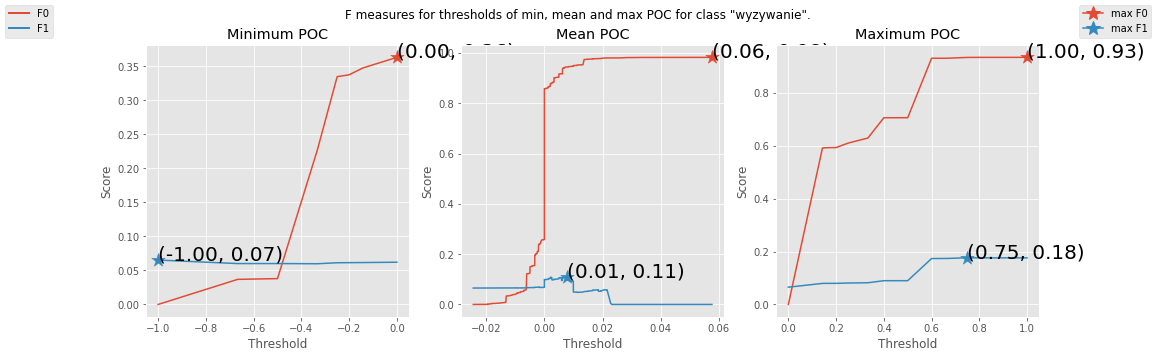

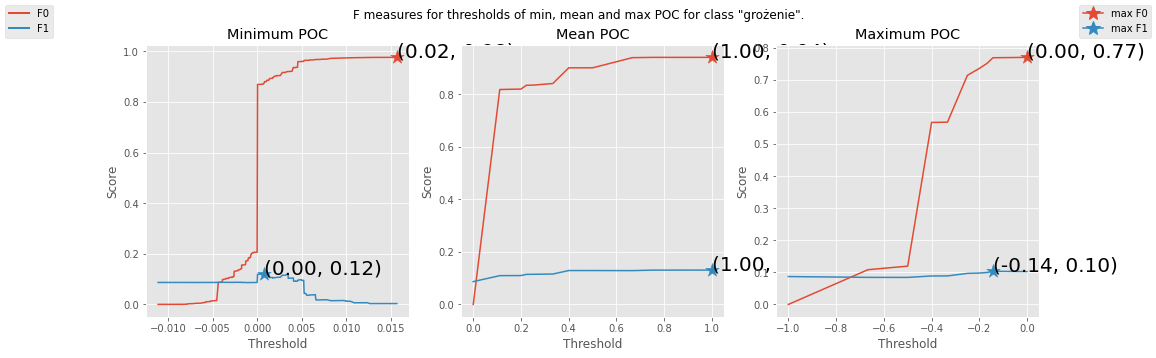

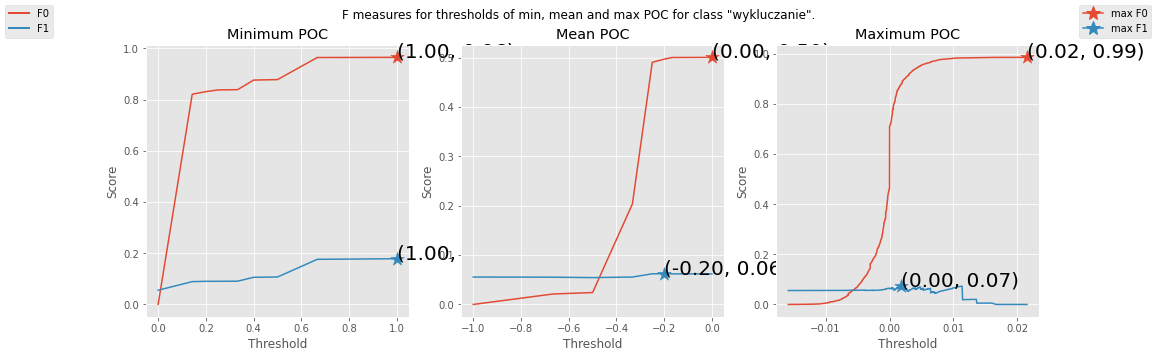

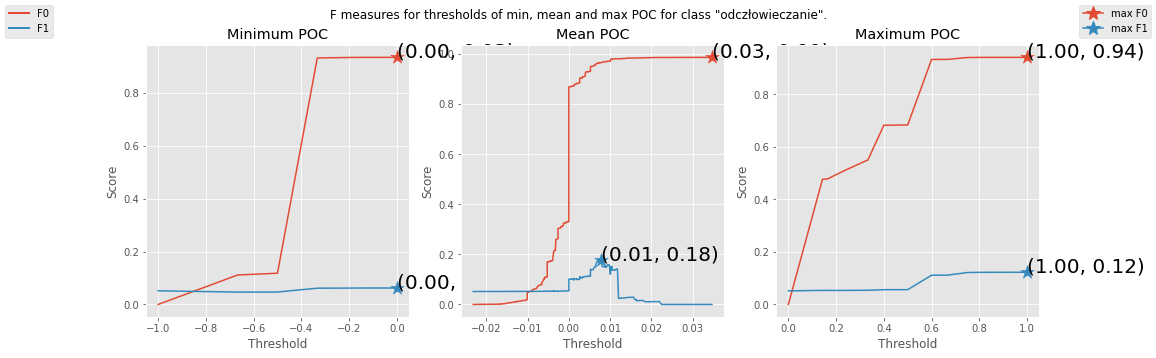

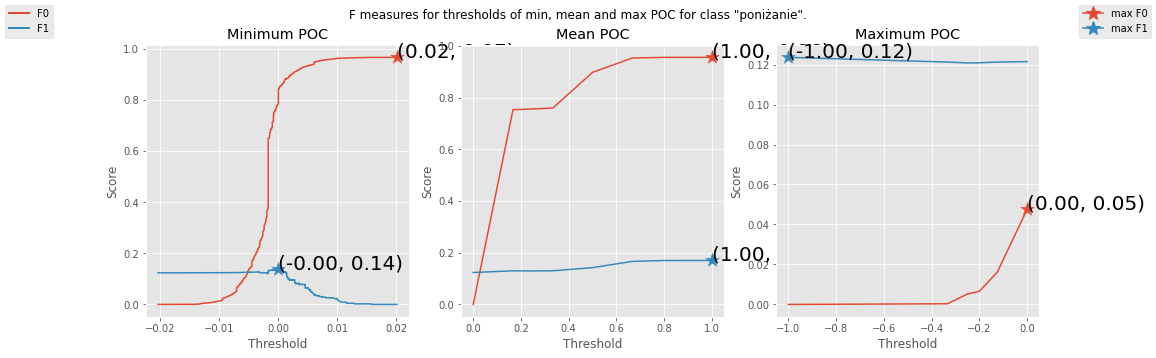

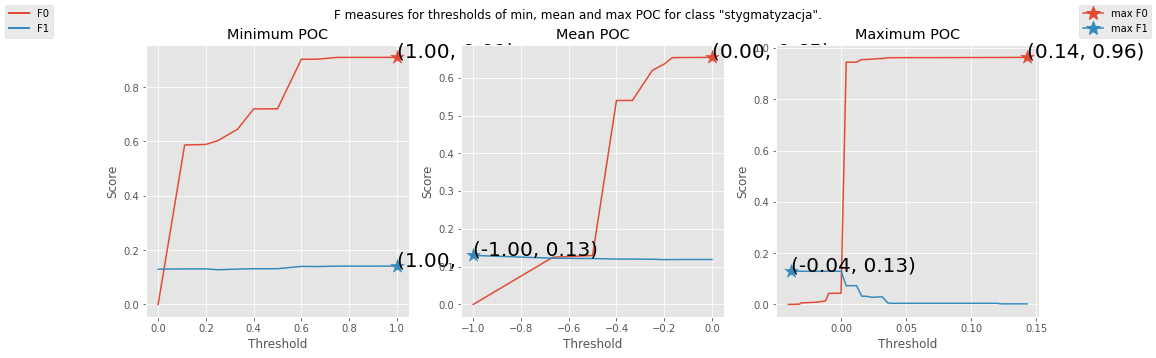

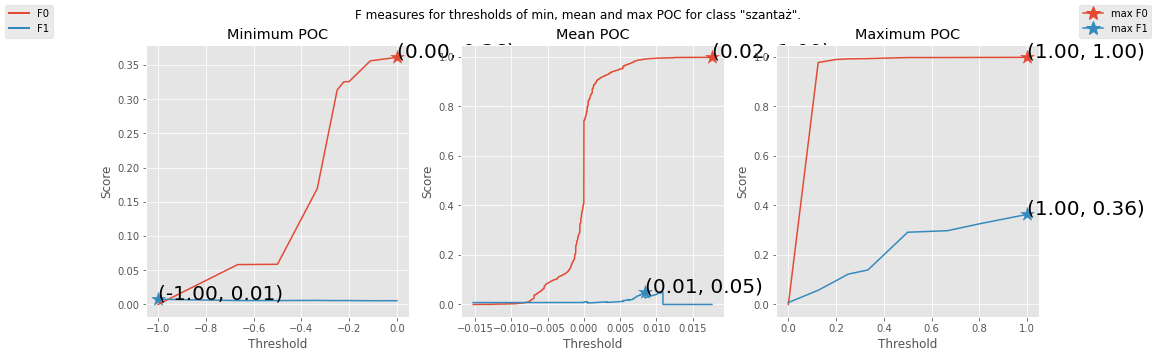

In [9]:
clf.plot_f_measure_lines(X_data, y_data)

## Tests

### Test for all data
Predict for all data for each hate-speech class.

In [10]:
y_pred = clf.predict(X_data.values)

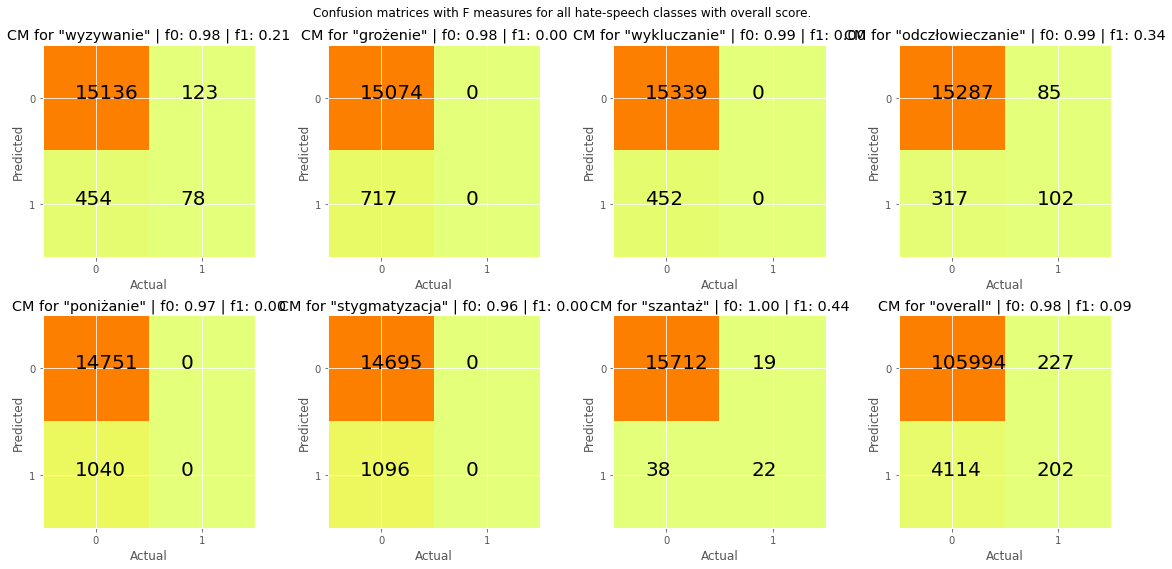

In [11]:
confusion_matrices(y_data.values, y_pred)

### Test 1

In [12]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be 'stygmatyzacja' and 'poniżanie' as (1).

### Test 2

In [13]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2.flatten()))

{'wyzywanie': 1,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically 'wyzywanie' is ok, but there also should be: 'grożenie' and 'stygmatyzacja' as (1). 

### Test 3

In [14]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'grożenie' as (1).